In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')



In [7]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [9]:
from prophet import Prophet

## Loading the dataset

In [10]:
df = pd.read_csv('/content/Walmart DataSet.csv')

In [11]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [12]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.sort_values(['Store', 'Date'], inplace = True)
df.set_index('Date', inplace = True)

In [13]:
df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106
2010-02-12,1,1641957.44,1,38.51,2.548,211.242170,8.106
2010-02-19,1,1611968.17,0,39.93,2.514,211.289143,8.106
2010-02-26,1,1409727.59,0,46.63,2.561,211.319643,8.106
2010-03-05,1,1554806.68,0,46.50,2.625,211.350143,8.106


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6435 entries, 2010-02-05 to 2012-10-26
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Weekly_Sales  6435 non-null   float64
 2   Holiday_Flag  6435 non-null   int64  
 3   Temperature   6435 non-null   float64
 4   Fuel_Price    6435 non-null   float64
 5   CPI           6435 non-null   float64
 6   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 402.2 KB


In [15]:
df.head().T

Date,2010-02-05,2010-02-12,2010-02-19,2010-02-26,2010-03-05
Store,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
Weekly_Sales,1.643691e+06,1.641957e+06,1.611968e+06,1.409728e+06,1.554807e+06
Holiday_Flag,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Temperature,4.231000e+01,3.851000e+01,3.993000e+01,4.663000e+01,4.650000e+01
Fuel_Price,2.572000e+00,2.548000e+00,2.514000e+00,2.561000e+00,2.625000e+00
CPI,2.110964e+02,2.112422e+02,2.112891e+02,2.113196e+02,2.113501e+02
Unemployment,8.106000e+00,8.106000e+00,8.106000e+00,8.106000e+00,8.106000e+00


## Data Processing

In [16]:
df.isnull().sum()

,0
Store,0
Weekly_Sales,0
Holiday_Flag,0
Temperature,0
Fuel_Price,0
CPI,0
Unemployment,0


In [17]:
df.shape

(6435, 7)

In [18]:
df.duplicated().sum()

np.int64(0)

In [19]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


## Finding outliers

In [20]:
num_columns = df.select_dtypes(include=np.number).columns
num_columns

Index(['Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price',
       'CPI', 'Unemployment'],
      dtype='object')

In [21]:
num_columns = num_columns.drop('Holiday_Flag')

In [22]:
num_columns

Index(['Store', 'Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment'],
      dtype='object')

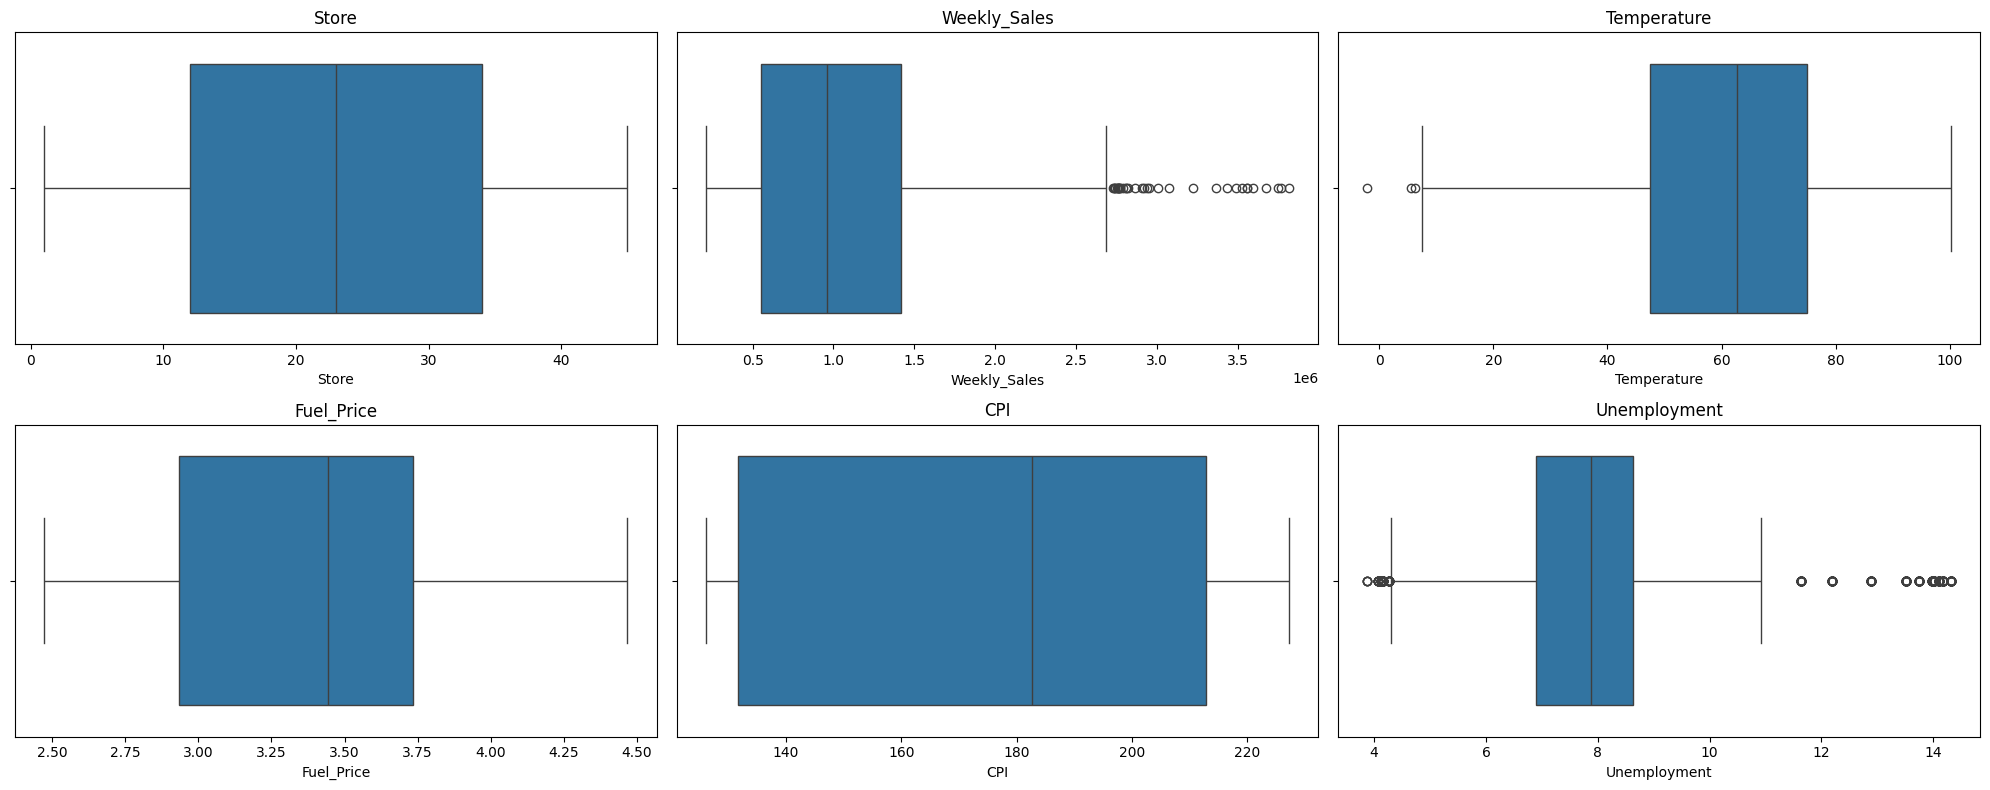

In [23]:
plt.figure(figsize=(20,8))

for i, col in enumerate(num_columns):
  plt.subplot(2,3,i+1)
  sns.boxplot(x = df[col])
  plt.tight_layout()
  plt.title(col)
plt.show()

## EDA

# Store vs weekly sales

In [24]:
df_store_sales = df.groupby('Store')['Weekly_Sales'].sum().reset_index()

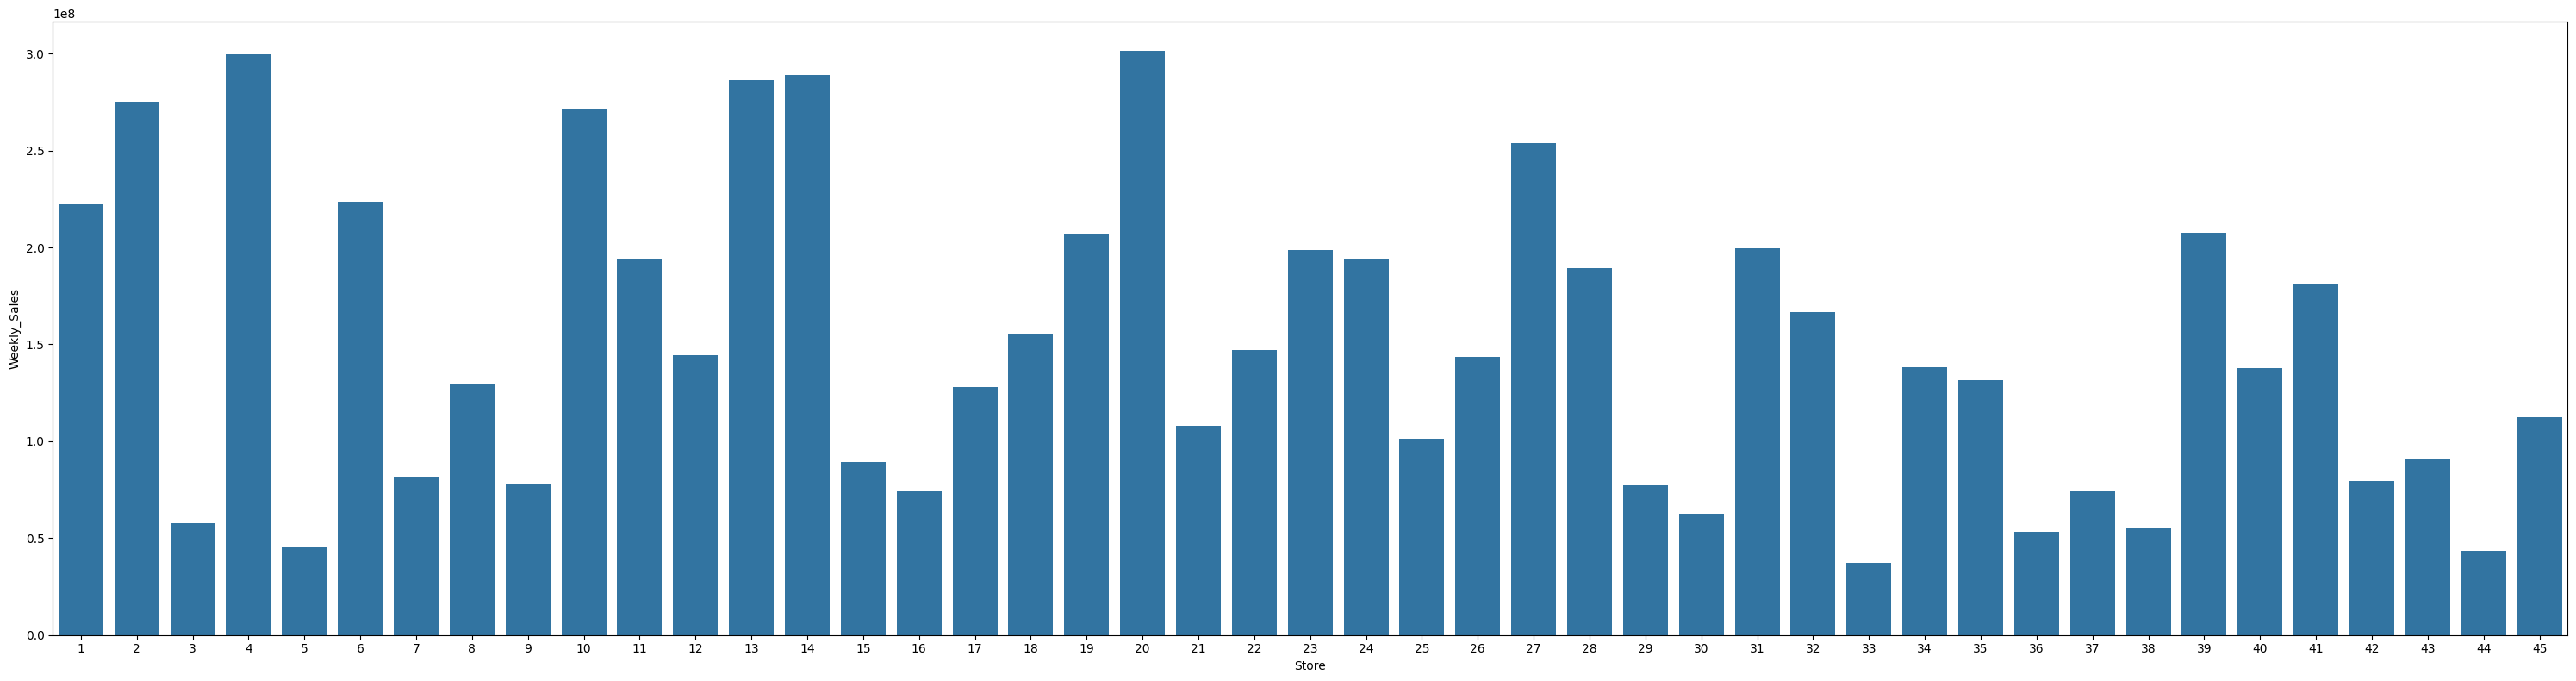

In [25]:
plt.figure(figsize = (30,8))
sns.barplot(x='Store', y = 'Weekly_Sales', data = df_store_sales)
plt.tight_layout()
plt.show()

# Top 10 stores

In [26]:
top_ten_stores = df_store_sales.sort_values(by="Weekly_Sales", ascending = False).head(10)

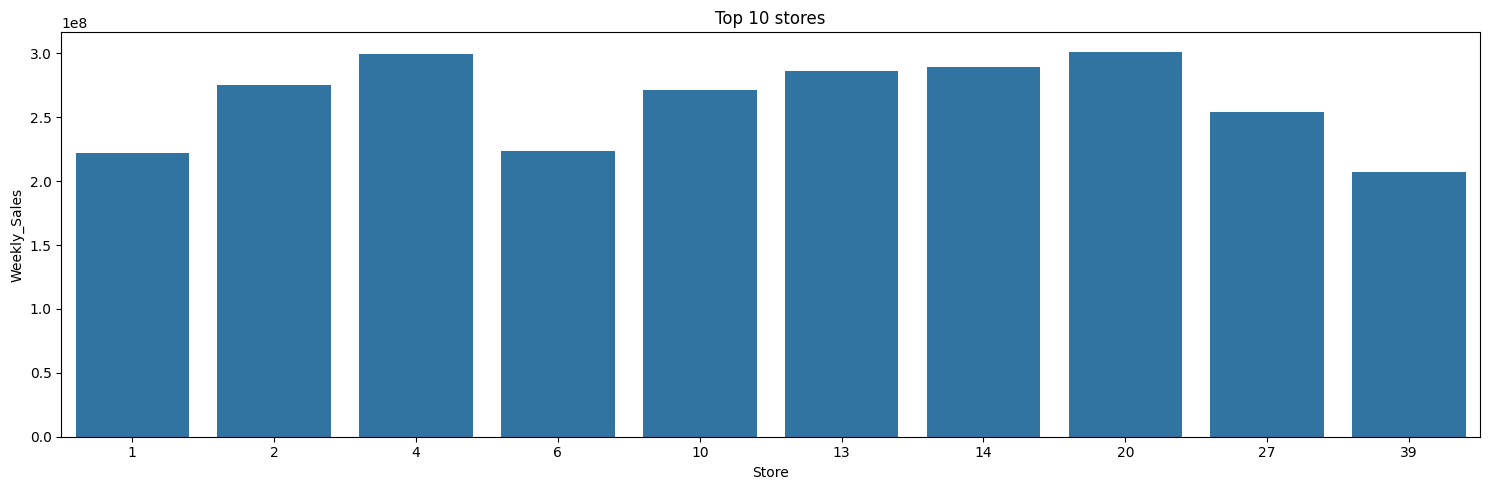

In [27]:
plt.figure(figsize=(15,5))
sns.barplot(x = 'Store', y = 'Weekly_Sales', data = top_ten_stores)
plt.title('Top 10 stores')
plt.tight_layout()
plt.show()

# Date vs weekly sales

In [28]:
df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106
2010-02-12,1,1641957.44,1,38.51,2.548,211.242170,8.106
2010-02-19,1,1611968.17,0,39.93,2.514,211.289143,8.106
2010-02-26,1,1409727.59,0,46.63,2.561,211.319643,8.106
2010-03-05,1,1554806.68,0,46.50,2.625,211.350143,8.106


In [29]:
df_date_sales = df.groupby('Date')['Weekly_Sales'].sum().reset_index()
df_date_sales = df_date_sales.sort_values(by='Date', ascending=True)
df_date_sales.head(5)

,Date,Weekly_Sales
0,2010-02-05,49750740.50
1,2010-02-12,48336677.63
2,2010-02-19,48276993.78
3,2010-02-26,43968571.13
4,2010-03-05,46871470.30


In [30]:
df_date_sales.shape

(143, 2)

Text(0, 0.5, 'Sales')

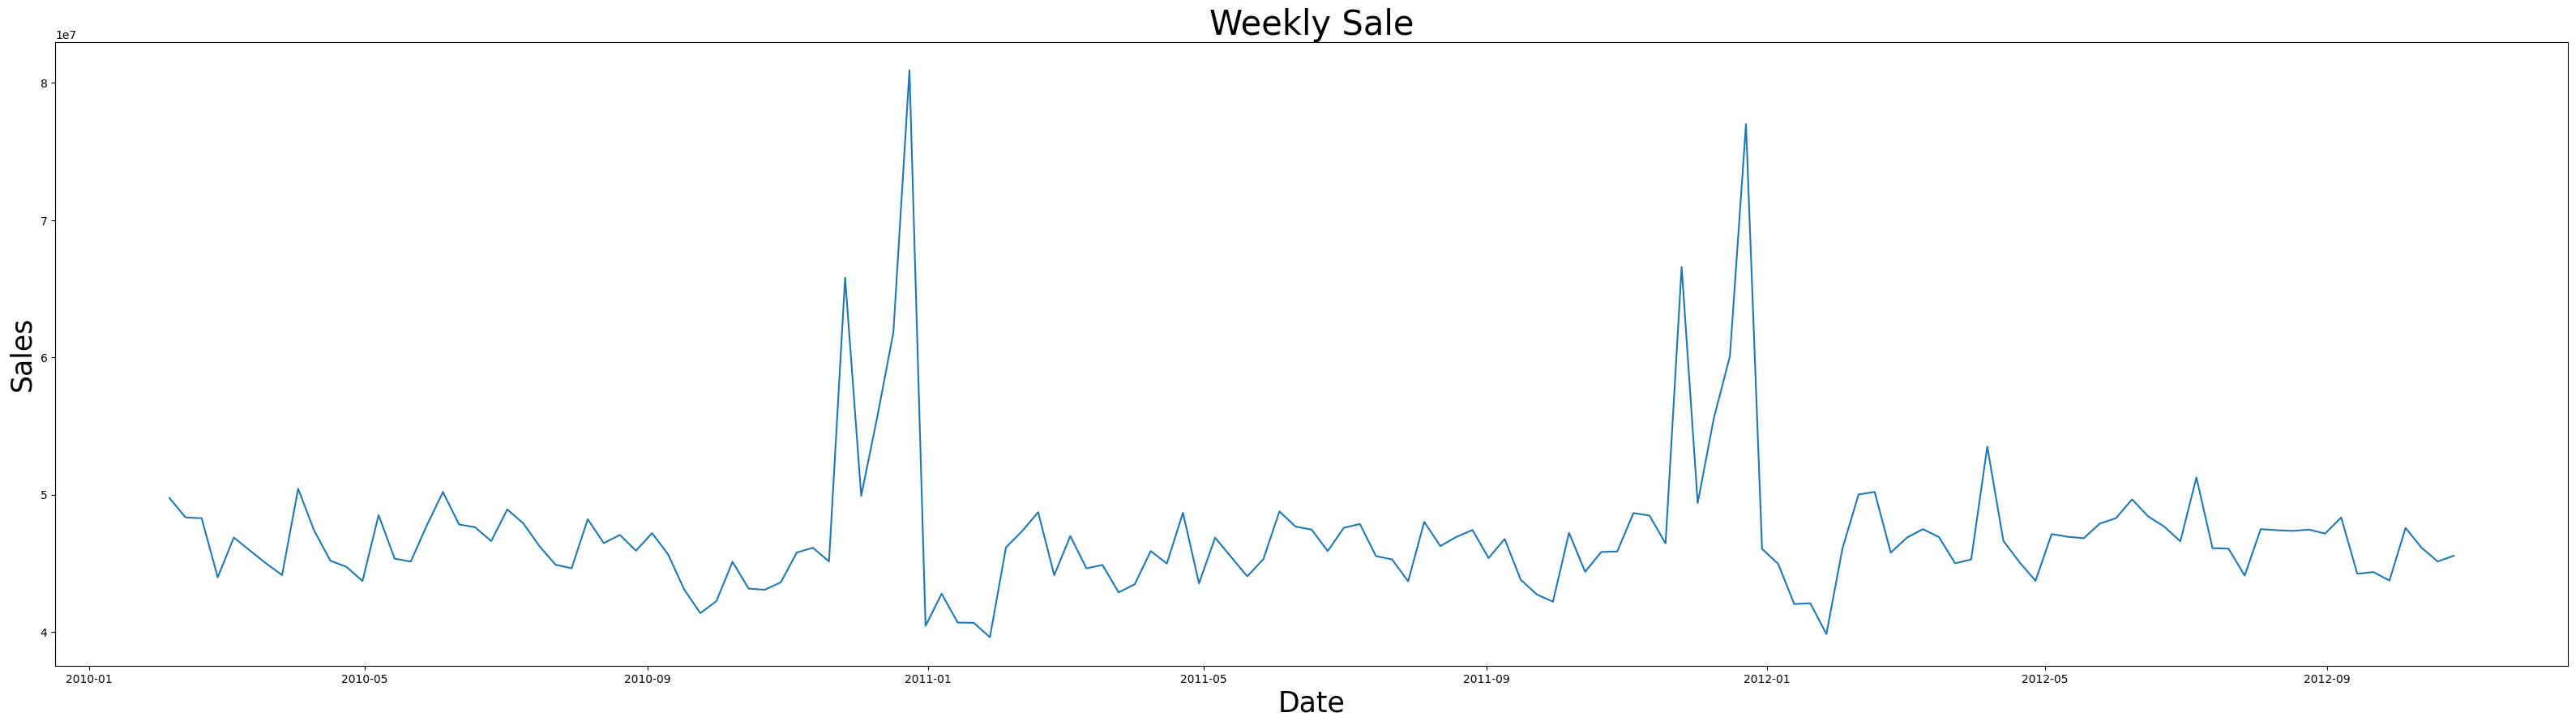

In [31]:
plt.figure(figsize=(40,10))
sns.lineplot(x='Date',y='Weekly_Sales',data=df_date_sales)
plt.title('Weekly Sale',fontsize=30)
plt.xlabel('Date',fontsize=25)
plt.ylabel('Sales',fontsize=25)

In [32]:
df['Quarters'] = df.index.to_period("Q")

In [33]:
df_quarter_sales = df.groupby('Quarters')['Weekly_Sales'].sum().reset_index()

In [34]:
df_quarter_sales

,Quarters,Weekly_Sales
0,2010Q1,3.722528e+08
1,2010Q2,6.103695e+08
2,2010Q3,5.974881e+08
3,2010Q4,7.087757e+08
4,2011Q1,5.293917e+08
5,2011Q2,5.979481e+08
6,2011Q3,6.393585e+08
7,2011Q4,6.815017e+08
8,2012Q1,5.924677e+08
9,2012Q2,6.182977e+08


<Axes: xlabel='Quarters', ylabel='Weekly_Sales'>

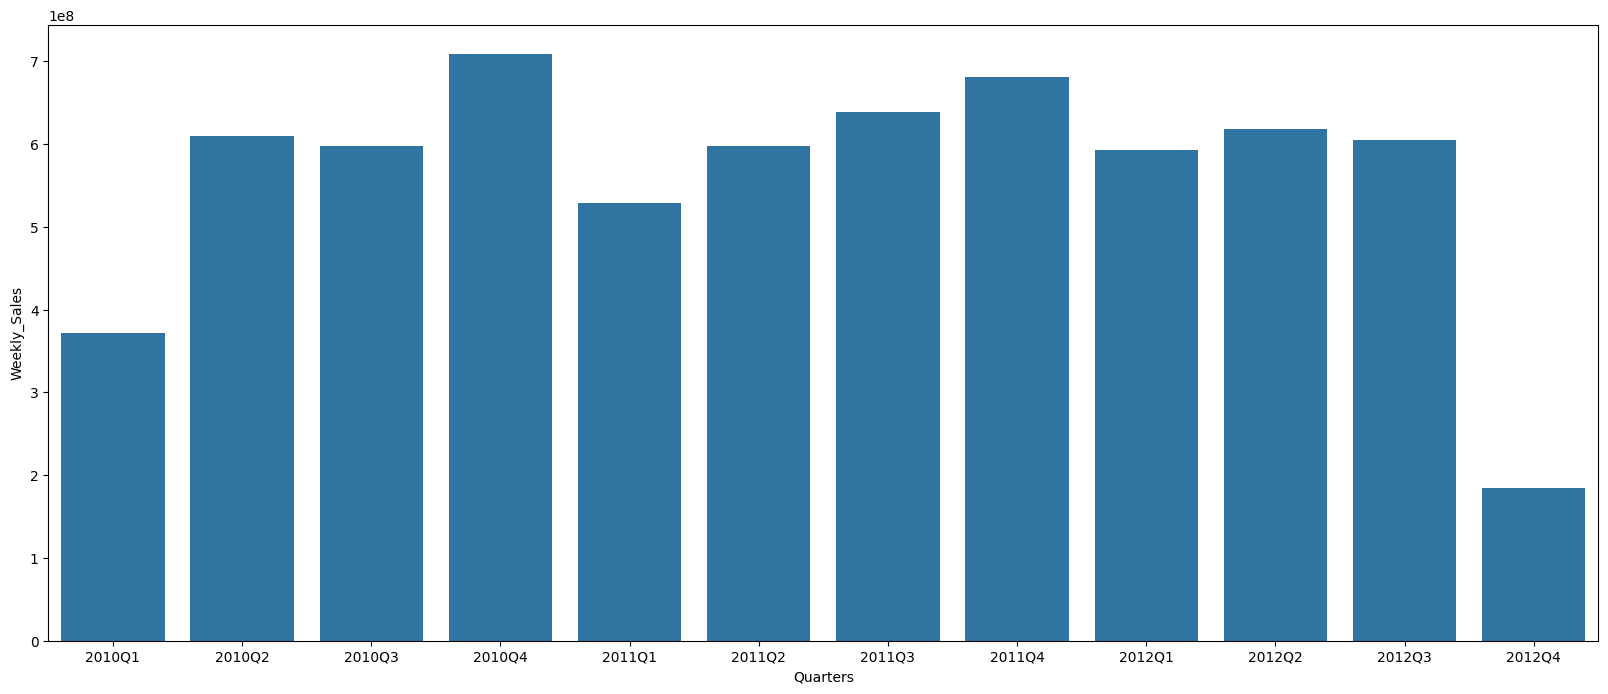

In [35]:
plt.figure(figsize=(20,8))
sns.barplot(x='Quarters',y='Weekly_Sales',data=df_quarter_sales)

# Sales vs Holidays

In [36]:
df['Holiday_Flag'].value_counts()

,count
Holiday_Flag,
0,5985
1,450


In [37]:
# Creating a new datafram that contains holiday and weekly sales summation
df_Hf_Sales = df.groupby('Holiday_Flag')['Weekly_Sales'].sum().reset_index()

In [38]:
df_Hf_Sales

,Holiday_Flag,Weekly_Sales
0,0,6.231919e+09
1,1,5.052996e+08


<Axes: xlabel='Holiday_Flag', ylabel='Weekly_Sales'>

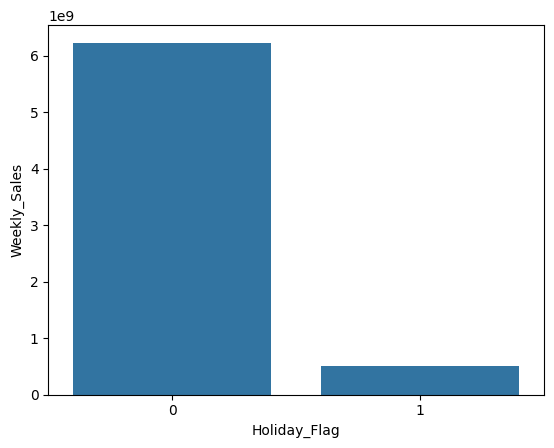

In [39]:
sns.barplot(x='Holiday_Flag',y='Weekly_Sales',data=df_Hf_Sales) # Plotting the distribution

## Statistical analysis

In [40]:
from sklearn.preprocessing import LabelEncoder
Le = LabelEncoder()

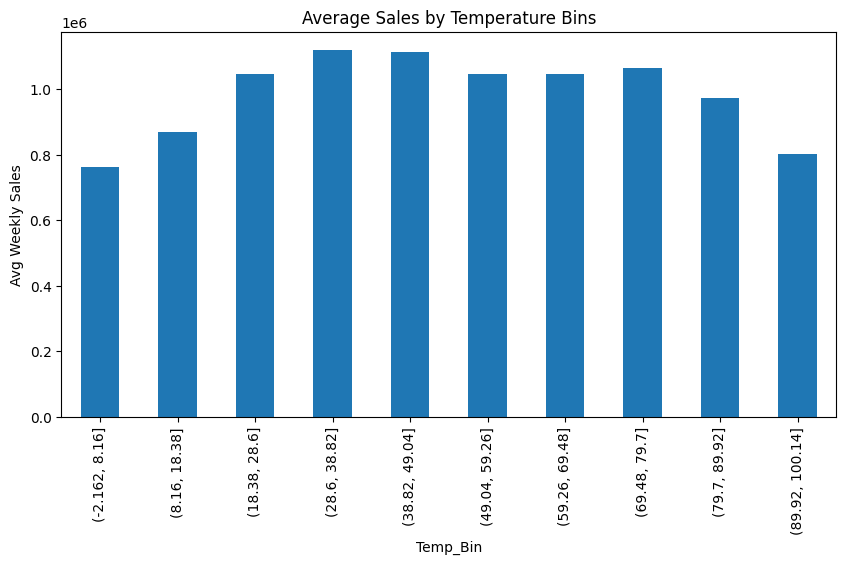

In [41]:
# Sales vs. Temperature (binned)
df['Temp_Bin'] = pd.cut(df['Temperature'], bins=10)
temp_sales = df.groupby('Temp_Bin')['Weekly_Sales'].mean()
temp_sales.plot(kind='bar', figsize=(10,5))
plt.title('Average Sales by Temperature Bins')
plt.ylabel('Avg Weekly Sales')
plt.show()

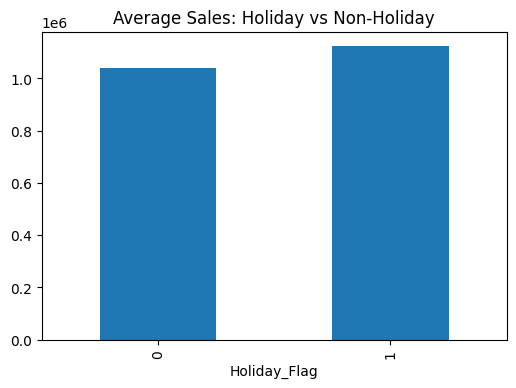

In [42]:
# Sales vs. Holiday Flag
holiday_sales = df.groupby('Holiday_Flag')['Weekly_Sales'].mean()
holiday_sales.plot(kind='bar', figsize=(6,4))
plt.title('Average Sales: Holiday vs Non-Holiday')
plt.show()

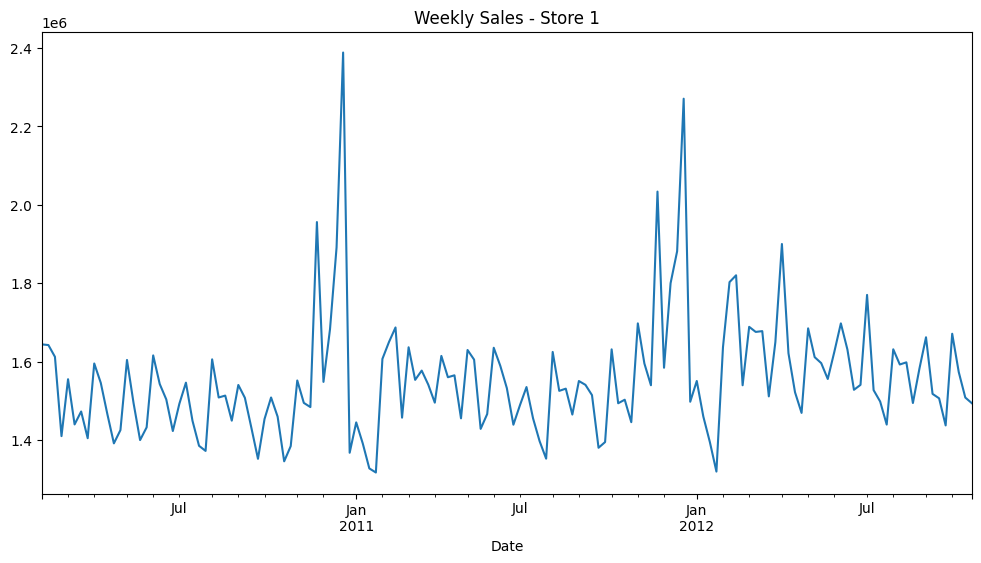

In [43]:
# Time Series Plot for Store 1
store1 = df[df['Store'] == 1]['Weekly_Sales']
store1.plot(figsize=(12,6))
plt.title('Weekly Sales - Store 1')
plt.show()

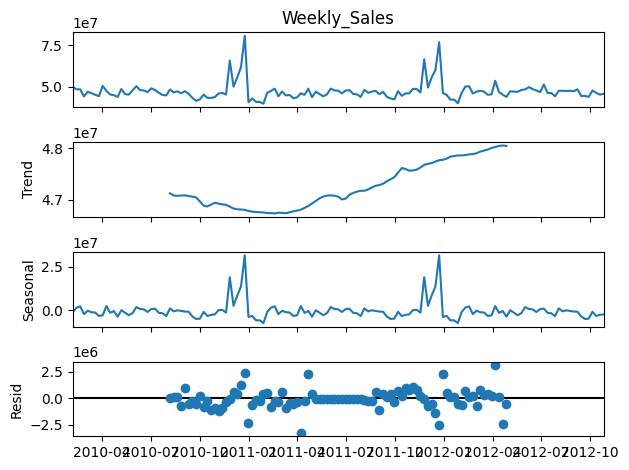

In [44]:
# Seasonal Decomposition (overall sales for demo)
overall_sales = df.groupby(df.index)['Weekly_Sales'].sum()
decomp = seasonal_decompose(overall_sales, model='additive', period=52)
decomp.plot()
plt.show()

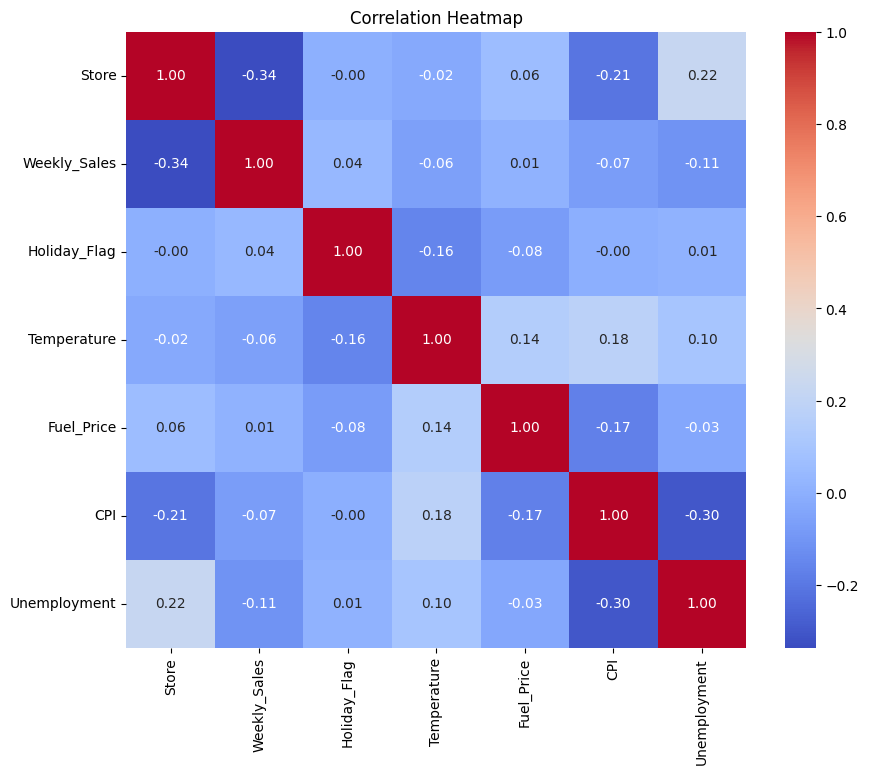

In [45]:
# corelation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.drop(columns=['Quarters', 'Temp_Bin']).corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Forcasting preparation

In [46]:
# using store 1 for example
data = df[df['Store']==1]
sales = data['Weekly_Sales']
exog_cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Holiday_Flag']
exog = data[exog_cols]

In [47]:
## train test split. Taking last 12 weeks as test
train_size = len(sales)-12
train_sales, test_sales = sales[:train_size], sales[train_size:]
train_exog, test_exog = exog[:train_size], exog[train_size:]

# Making models

In [48]:
models_test_preds = {}
models_forcasts = {}

## ARIMA

In [49]:
arima_model = ARIMA(train_sales, order=(1,1,1))
arima_fit = arima_model.fit()
arima_test_pred = arima_fit.forecast(steps=len(test_sales))
arima_next_12 = arima_fit.forecast(steps=12)
models_test_preds['ARIMA'] = arima_test_pred
models_forcasts['ARIMA'] = arima_next_12

## SARIMAX

In [50]:
sarimax_model = SARIMAX(train_sales, exog=train_exog,
                        order=(1,1,1), seasonal_order=(1,1,1,52))
sarimax_fit = sarimax_model.fit(disp=False, maxiter=1000)
sarimax_test_pred = sarimax_fit.get_forecast(steps=len(test_sales), exog=test_exog).predicted_mean
sarimax_next_12 = sarimax_fit.get_forecast(steps=12, exog=test_exog.iloc[-12:]).predicted_mean
models_test_preds['SARIMAX'] = sarimax_test_pred
models_forcasts['SARIMAX'] = sarimax_next_12

In [51]:
prophet_available = True

if prophet_available:
    # Prepare the dataframe for Prophet
    prophet_df = pd.DataFrame({'ds': sales.index, 'y': sales.values})
    prophet_df = prophet_df.merge(exog.reset_index(), left_on='ds', right_on='Date', how='left')
    prophet_df.drop('Date', axis=1, inplace=True)

    m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    for col in exog_cols:
        m.add_regressor(col)

    # Fit the model on the training data
    m.fit(prophet_df.iloc[:train_size])

    # 1. Prediction for the test set
    # Create the prediction dataframe for the test period, already contains 'ds' and exog_cols
    prophet_test_future = prophet_df.iloc[train_size:].copy()
    prophet_test_forecast = m.predict(prophet_test_future)
    prophet_test_pred = prophet_test_forecast['yhat'].values
    models_test_preds['Prophet'] = prophet_test_pred

    # 2. Forecast for the next 12 periods (actual future beyond the entire dataset)
    # Get the last date of the full dataset (train + test)
    last_historical_date = sales.index[-1]

    # Create a future dataframe for the next 12 periods, starting AFTER the last historical date
    future_dates_for_next_12 = pd.date_range(start=last_historical_date, periods=13, freq='W-FRI')[1:]
    prophet_future_for_next_12 = pd.DataFrame({'ds': future_dates_for_next_12})

    # For exogenous variables, repeat the last known values from the dataset
    last_exog_values = exog.iloc[-1][exog_cols].values
    for col_idx, col_name in enumerate(exog_cols):
        prophet_future_for_next_12[col_name] = last_exog_values[col_idx]

    # Predict the next 12 periods
    prophet_next_12_forecast = m.predict(prophet_future_for_next_12)
    prophet_next_12 = prophet_next_12_forecast['yhat'].values
    models_forcasts['Prophet'] = prophet_next_12

##LSTM

In [52]:
class TimeSeriesDataset(Dataset):
  def __init__(self, X,y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

## Preparing data


In [53]:
scaler_sales = MinMaxScaler()
scaler_exog = MinMaxScaler()

In [54]:
scaled_sales = scaler_sales.fit_transform(np.array(sales).reshape(-1, 1))
scaled_exog = scaler_exog.fit_transform(exog)

In [55]:
seq_len = 12
X, y = [], []

In [56]:
for i in range(len(scaled_sales) - seq_len):
  X.append(np.hstack([scaled_sales[i:i+seq_len], scaled_exog[i:i+seq_len]]))
  y.append(scaled_sales[i+seq_len])

In [57]:
X = np.array(X)
y = np.array(y)

In [58]:
# Train/test split
train_idx = train_size - seq_len
X_train, y_train = X[:train_idx], y[:train_idx]
X_test, y_test = X[train_idx:], y[train_idx:]

In [59]:
dataset_train = TimeSeriesDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
dataloader = DataLoader(dataset_train, batch_size=32, shuffle=True)

In [60]:
class LSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size= 64, num_layers=2):
    super().__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    out, _ = self.lstm(x)
    return self.fc(out[:, -1, :])

In [61]:
model = LSTMModel(input_size=X_train.shape[2])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Train the model

In [62]:
epochs = 1000
for epoch in range(epochs):
    model.train()
    for batch_x, batch_y in dataloader:
        optimizer.zero_grad()
        pred = model(batch_x)
        loss = criterion(pred, batch_y)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 20 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}')

Epoch 20/1000, Loss: 0.049249
Epoch 40/1000, Loss: 0.004553
Epoch 60/1000, Loss: 0.010701
Epoch 80/1000, Loss: 0.004920
Epoch 100/1000, Loss: 0.015624
Epoch 120/1000, Loss: 0.020788
Epoch 140/1000, Loss: 0.021040
Epoch 160/1000, Loss: 0.008800
Epoch 180/1000, Loss: 0.004481
Epoch 200/1000, Loss: 0.005152
Epoch 220/1000, Loss: 0.002645
Epoch 240/1000, Loss: 0.007122
Epoch 260/1000, Loss: 0.002726
Epoch 280/1000, Loss: 0.003801
Epoch 300/1000, Loss: 0.002560
Epoch 320/1000, Loss: 0.002655
Epoch 340/1000, Loss: 0.001478
Epoch 360/1000, Loss: 0.001656
Epoch 380/1000, Loss: 0.000916
Epoch 400/1000, Loss: 0.000437
Epoch 420/1000, Loss: 0.000703
Epoch 440/1000, Loss: 0.001390
Epoch 460/1000, Loss: 0.000605
Epoch 480/1000, Loss: 0.000831
Epoch 500/1000, Loss: 0.000401
Epoch 520/1000, Loss: 0.000451
Epoch 540/1000, Loss: 0.000439
Epoch 560/1000, Loss: 0.000428
Epoch 580/1000, Loss: 0.000286
Epoch 600/1000, Loss: 0.000390
Epoch 620/1000, Loss: 0.000540
Epoch 640/1000, Loss: 0.000278
Epoch 660/10

In [63]:
# Test predictions
model.eval()
with torch.no_grad():
    lstm_test_pred_scaled = []
    for i in range(len(X_test)):
        pred = model(torch.FloatTensor(X_test[i:i+1])).item()
        lstm_test_pred_scaled.append(pred)
lstm_test_pred = scaler_sales.inverse_transform(np.array(lstm_test_pred_scaled).reshape(-1, 1)).flatten()

In [66]:
# Next 12 weeks forecast (autoregressive)
future_preds = []
current_seq = torch.FloatTensor(X[-1:])  # last sequence (batch_size=1, seq_len, input_size)

# Get the last known scaled exogenous variables, assumed constant for future forecasts
last_known_scaled_exog_tensor = torch.FloatTensor(scaled_exog[-1]) # Shape (5,)

model.eval() # Set model to evaluation mode once
for _ in range(12):
    with torch.no_grad():
        # Make prediction with the current sequence
        pred_scaled = model(current_seq).item()
    future_preds.append(pred_scaled)

    # Construct the new last timestep for the next sequence
    # It consists of the new predicted sales (scaled) and the constant scaled exogenous features
    new_last_timestep_features = torch.cat((torch.tensor([pred_scaled], dtype=torch.float32),
                                            last_known_scaled_exog_tensor), dim=0) # Shape (6,)

    # Shift the current_seq: remove the oldest timestep and append the new one
    # current_seq[:, 1:, :] has shape (1, seq_len-1, input_size) = (1, 11, 6)
    # new_last_timestep_features.unsqueeze(0).unsqueeze(0) gives (1, 1, 6) - adds batch and sequence length dimensions
    current_seq = torch.cat((current_seq[:, 1:, :], new_last_timestep_features.unsqueeze(0).unsqueeze(0)), dim=1)

lstm_next_12 = scaler_sales.inverse_transform(np.array(future_preds).reshape(-1, 1)).flatten()

models_test_preds['LSTM'] = lstm_test_pred
models_forcasts['LSTM'] = lstm_next_12

## Evaluation and comparison

In [68]:
def evaluate(true, pred):
    return {
        'RMSE': np.sqrt(mean_squared_error(true, pred)),
        'MAE': mean_absolute_error(true, pred),
        'MAPE (%)': mean_absolute_percentage_error(true, pred) * 100,
        'R²': r2_score(true, pred)
    }

In [69]:
results = {}
for name, pred in models_test_preds.items():
    results[name] = evaluate(test_sales, pred)

results_df = pd.DataFrame(results).T
print("\nModel Performance on Test Set (Last 12 Weeks):")
print(results_df.round(2))


Model Performance on Test Set (Last 12 Weeks):
              RMSE        MAE  MAPE (%)    R²
ARIMA     83663.40   70935.79      4.67 -0.49
SARIMAX  168196.48  159232.07     10.31 -5.02
Prophet   96584.16   78060.32      5.17 -0.98
LSTM      90184.06   81272.47      5.20 -0.73


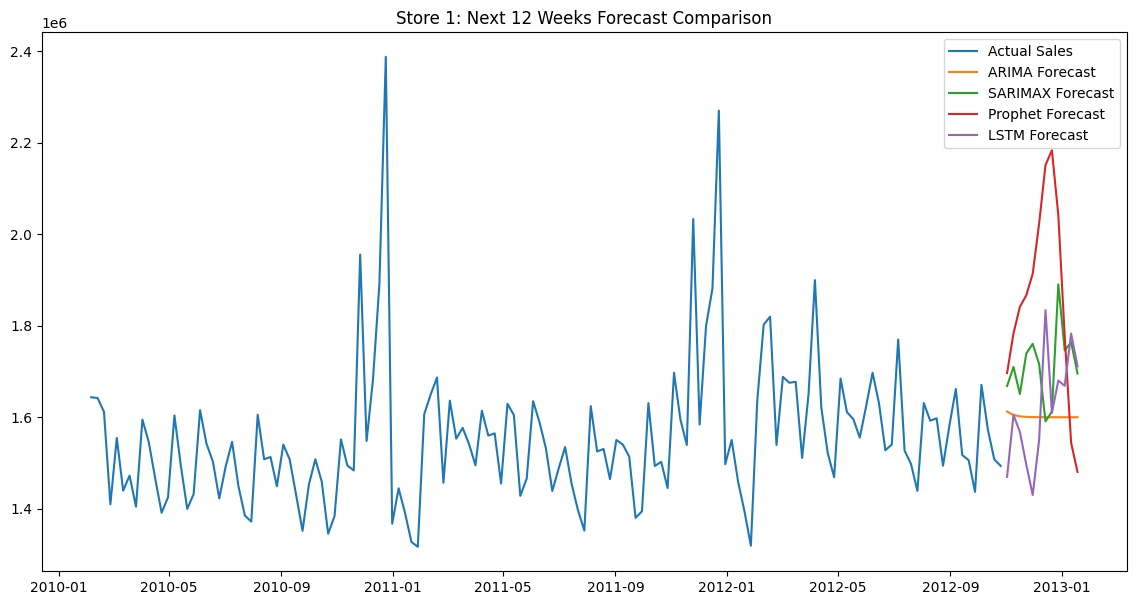

In [71]:
# Plot forecasts
plt.figure(figsize=(14, 7))
plt.plot(sales, label='Actual Sales')
for name, fc in models_forcasts.items():
    forecast_dates = pd.date_range(start=sales.index[-1] + pd.Timedelta(weeks=1), periods=12, freq='W-FRI')
    plt.plot(forecast_dates, fc, label=f'{name} Forecast')
plt.title('Store 1: Next 12 Weeks Forecast Comparison')
plt.legend()
plt.show()